In [1]:
import pandas as pd
import pickle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from scipy import stats
import statsmodels.api as sm
sns.set(font_scale = 1, style = 'darkgrid', rc={'figure.figsize':(7,5)})

Time periods:
1. Baseline period: 2005-2013
2. Intervention period: 2014-2020
3. Evaluation period: 2021-


1. Find the K nearest sponsoring units for each sponsoring unit for each year from 2005 to 2010(or other year)
    - Save distance
2. Sum distances, and find the K sponsoring units with smalles total distance
3. Calculate relative likelihood of unit inviting females, for each unit
4. Now find the sponsoring units that adopted different strategies from 2011 to 2020
    - Unit i have high likelihood of invited females, unit j have low likelihood of inviting females
        - Do this by finding units with large difference of likelihood
5. Increase in female attendees compare to baseline period
    - How is outcome for unit i vs unit j?

When finding the most different units in the interventon period, we substract units j from i. We care about real difference, not absolute. But when comparing different units, we care about normalized difference. Meaning it does not matter if unit i has the biggest or smallest relative likelihood.

The reason that we want the real difference, is that if they fluctuate a lot, and basically cancel each other out, this should not count as a big differrence. 

When finding Change in female attendees is measured in female ratio since the total number of attendees is increasing

# Method

1. Remove sponsoring units that have data for less than 5 years. These are too small for us to see anything.
2. Remove sponsoring units with less than 3 years in baseline. These do not have enough data to compare with
3. Remove sponsoring units with 20 or less researchers from 2005 to 2019
4. remove sponsoring units that is not in the baseline data. This is because we don't have anything to compare with, if it is not in baseline

we try with baseline 2005-2013


As starting point, we only use units with data from the entire period


# Functions

In [2]:
def getFemaleRatio(sponsoringUnits, invited_df, attendees_df, unitCol):
    index = 0
    femaleRatioInv_dict = {}
    femaleRatioAtt_dict = {}
    for i in sponsoringUnits:
        sponsoringUnitInv = invited_df[invited_df[unitCol] == i]
        sponsoringUnitAtt = attendees_df[attendees_df[unitCol] == i]
        invited_crossTab = pd.crosstab(index = sponsoringUnitInv.Year, columns = sponsoringUnitInv.Gender,
                    normalize = "index")['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_inv'})
        invited_crossTab['SponsoringUnitName'] = i
    
        attendees_crossTab = pd.crosstab(index = sponsoringUnitAtt.Year, columns = sponsoringUnitAtt.Gender,
                    normalize = 'index')['Female'].reset_index().rename(columns = {'Female': 'FemaleRatio_att'})
    
        attendees_crossTab['SponsoringUnitName'] = i
    
        invitedDict = invited_crossTab.to_dict('list')
        attendeesDict = attendees_crossTab.to_dict('list')
        femaleRatioInv_dict[index] = invitedDict
        femaleRatioAtt_dict[index] = attendeesDict
        index += 1

    return femaleRatioInv_dict, femaleRatioAtt_dict

In [3]:
def standardizeColumn(df, columnName):
    standardizedColumn = (df[columnName] - df[columnName].mean())/(df[columnName].std())
    
    return standardizedColumn

In [4]:
#get distances
def KNN_distances(df, features):
    neighborDict = {}
    index = 0
    df_stand = df.copy()
    units = df.SponsoringUnitName.unique()
    #unitDist = np.zeros((len(units), len(units)))

    for c in features:
        df_stand[c] = standardizeColumn(df_stand, c) #standardize data
        
    years = df.Year.unique()
    for y in years:
        year_df = df_stand[df_stand.Year == y]
        
        #do KNN
        neighbors = NearestNeighbors(n_neighbors = len(units), metric = 'manhattan').fit(year_df[features])
        kNeighbor_dist, kNeighbor_ind = neighbors.kneighbors(year_df[features])
        
        for i in range(0, len(units)):
            neighborDict[index] = {'SponsoringUnit': units[i], 'Year': y, 'Neighbor': kNeighbor_ind[i,1:], 'Distance': kNeighbor_dist[i,1:]} #don't select unit itself as neighbor
            index += 1
     
    neighbor_df = pd.DataFrame.from_dict(neighborDict, orient = 'index').explode(['Neighbor', 'Distance'])
    neighborIndex_df = pd.DataFrame(units).rename(columns = {0: 'NeighborUnit'})
    return neighbor_df, neighborIndex_df

In [5]:
#get similar untis within threshold
def KNN_similarUnits(df, features):
    KNN_df, unitIndex = KNN_distances(df, features) #get distance
    KNN_similarSponsUnits = KNN_df.merge(unitIndex, how = 'left', left_on = 'Neighbor', right_on = unitIndex.index)[['SponsoringUnit', 'Year', 'Distance', 'NeighborUnit']] #add name of NeighborUnit
    distances = KNN_similarSponsUnits.groupby(['SponsoringUnit', 'NeighborUnit']).sum(numeric_only = False) #sum distance for each unit and neighbor
    quantile = distances.Distance.quantile(q = 0.5) #threshold of summed distance
    similarUnits =  distances[distances.Distance <= quantile].reset_index()[['SponsoringUnit', 'NeighborUnit', 'Distance']] #df of units similar enough
  
    return similarUnits

In [40]:
def getDifferentUnits(likelihood_df, similarUnits):
    avgLikelihood = likelihood_df.groupby('SponsoringUnit').mean()
    
    #q025 = avgLikelihood.quantile(q = 0.25)['Avg_likelihood']
    #q075 = avgLikelihood.quantile(q = 0.75)['Avg_likelihood']
    #print(q025, q075)
    #categories = ['Low', 'Medium', 'High']
    categories = ['Low', 'High']
    #conditions = [avgLikelihood.Avg_likelihood <= q025, 
     #         (avgLikelihood.Avg_likelihood > q025) & (avgLikelihood.Avg_likelihood < q075), 
      #       avgLikelihood.Avg_likelihood >= q075]
    conditions = [avgLikelihood.Avg_likelihood < 1, avgLikelihood.Avg_likelihood >= 1]

    avgLikelihood['LikelihoodCat'] = np.select(conditions, categories, default = 'Unknown')
    avgLikelihood = avgLikelihood.reset_index()
    #likelihood_cat = avgLikelihood.assign(likelihoodCat = 
     #                           pd.cut(avgLikelihood.Avg_likelihood, bins = [0, q025, q075, 10], 
      #                                 labels = ['Low', 'Medium', 'High'])).reset_index() #create categories
    likelihoodCat_df = similarUnits.merge(avgLikelihood[['SponsoringUnit', 'LikelihoodCat']], how = 'left', on = 'SponsoringUnit') #add likelihood category for sponsoring unit
    likelihoodCat_df = likelihoodCat_df.merge(avgLikelihood[['SponsoringUnit', 'LikelihoodCat']], how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit')
    similarunits_likelihood = likelihoodCat_df.rename(columns = {'SponsoringUnit_x': 'SponsoringUnit', 'LikelihoodCat_x': 'Likelihood_SponsoringUnit', 'LikelihoodCat_y': 'Likelihood_Neighbor'})[['SponsoringUnit', 'NeighborUnit', 'Distance', 'Likelihood_SponsoringUnit', 'Likelihood_Neighbor']] #rename columns + choose columns
    
    differentUnits1 = similarunits_likelihood[(similarunits_likelihood.Likelihood_SponsoringUnit == 'Low') & (similarunits_likelihood.Likelihood_Neighbor == 'High')]
    differentUnits2 = similarunits_likelihood[(similarunits_likelihood.Likelihood_SponsoringUnit == 'High') & (similarunits_likelihood.Likelihood_Neighbor == 'Low')]
    differentUnits = pd.concat([differentUnits1, differentUnits2])
    return differentUnits

In [41]:
def getRelativeChange(newVal, oldVal):
    change = (newVal - oldVal) / oldVal
    
    return change

In [42]:
def getChange(units, baseline, evaluation):
    relativeChange_dict = {}
    index = 0
    for i in units:
        baseline_att = baseline[(baseline.SponsoringUnitName == i) & (baseline.SessionType == 'attendee')] #baseline data for attendees in unit i
        
        #get gender ratio
        genderRatio = pd.crosstab(index = baseline_att.Year, columns = baseline_att.Gender, normalize = 'index')
        
        #evaluation
        eval_att = evaluation[(evaluation.SponsoringUnitName == i) & (evaluation.SessionType == 'attendee')] #data for i in evaluation period
        sessionTypeEval = pd.crosstab(index = eval_att.Year, columns = eval_att.Gender, normalize = 'index')
        relativeChange = getRelativeChange(sessionTypeEval.Female.mean(), genderRatio.Female.mean()) #get relative change of female attendees
        relativeChange_dict[index] = {'SponsoringUnit': i, 'RelativeChangeAtt': relativeChange} #save relative change in dictionary
        index += 1
        
    relativeChange_df = pd.DataFrame.from_dict(relativeChange_dict, orient = 'index')
    return relativeChange_df

In [43]:
def plotLineplot(df, unit, likelihood): #add color
    years = df.index
    sns.lineplot(data = df, x = 'Year', y = 'Female', label = unit + ": " + str(likelihood))
    plt.axvline(2013.5, color = 'black', linewidth = 1).set_linestyle("--")
    plt.axvline(2020.5, color = 'black', linewidth = 1).set_linestyle("--")
    plt.ylabel('Female ratio')
    plt.xticks(np.arange(min(years), max(years)+1, 2.0))
    
    result = stats.linregress(df.index, df.Female)
    print(result.slope)

In [44]:
def plotGenderRatio(unit_i, unit_j, df, likelihood):
    sessionType_i = df[(df.SponsoringUnitName == unit_i) & (df.SessionType == 'attendee')]
    sessionType_j = df[(df.SponsoringUnitName == unit_j) & (df.SessionType == 'attendee')]
    inv_i = df[(df.SponsoringUnitName == unit_i) & (df.SessionType == 'invited')]
    inv_j = df[(df.SponsoringUnitName == unit_j) & (df.SessionType == 'invited')]
        
    genderRatio_i = pd.crosstab(index = sessionType_i.Year, columns = sessionType_i.Gender, normalize = 'index')
    genderRatio_j = pd.crosstab(index = sessionType_j.Year, columns = sessionType_j.Gender, normalize = 'index')
    genderRatioInv_i = pd.crosstab(index = inv_i.Year, columns = inv_i.Gender, normalize = 'index')
    genderRatioInv_j = pd.crosstab(index = inv_j.Year, columns = inv_j.Gender, normalize = 'index')
    
    #average likelihood in intervention period for unit i and unit j
    likelihood_i = format(likelihood[likelihood.SponsoringUnit == unit_i]['Avg_likelihood'].mean(), '.2f')
    likelihood_j = format(likelihood[likelihood.SponsoringUnit == unit_j]['Avg_likelihood'].mean(), '.2f')
    
    plotLineplot(genderRatio_i, unit_i, likelihood_i)
    plotLineplot(genderRatio_j, unit_j, likelihood_j)
    #plotLineplot(genderRatioInv_i, unit_i, likelihood_i)
    #plotLineplot(genderRatioInv_j, unit_j, likelihood_j)
    plt.savefig("Figures/intervention_" + unit_i + "_" + unit_j + ".png", bbox_inches = 'tight')
    plt.show()

In [76]:
#load relative likelihoo + sponsoring unit data
likelihood1 = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood.pkl")
sponsUnitResearchers = pd.read_pickle("Files/Dataframes/researchers_sponsoringUnits.pkl")
likelihood2 = pd.read = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood2.pkl")
likelihood05_1 = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood05.pkl")
likelihood05_2 = pd.read_pickle("Files/Dataframes/sponsoringUnitsLikelihood2_05.pkl")

In [77]:
#define invited speakers and attendees
invited = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'invited']
attendees = sponsUnitResearchers[sponsUnitResearchers.SessionType == 'attendee']

In [78]:
#number of years with data for each sponsoring unit for invited speakers and attendees
invitedYearCount = invited.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()
attendeesYearCount = attendees.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().groupby('SponsoringUnitName').count().reset_index()

In [79]:
#count number of years for sponsorign units
yearCount_df = invitedYearCount[['SponsoringUnitName', 'Year']].rename(columns = {'Year': 'invitedYears'})
yearCount = yearCount_df.merge(attendeesYearCount[['SponsoringUnitName', 'Year']], how = 'outer', on = 'SponsoringUnitName').rename(columns = {'Year': 'attendeeYears'})

In [80]:
units = yearCount[(yearCount.invitedYears == 19) & (yearCount.attendeeYears == 19)].SponsoringUnitName.tolist() #sponsoring units

#only choose data for the chosen units
filteredData = sponsUnitResearchers[sponsUnitResearchers.SponsoringUnitName.isin(units)]

In [81]:
#define data for the three periods
interventionStart = 2013
interventionEnd = 2020

baselineData = filteredData[filteredData.Year <= interventionStart]
interventionData = filteredData[(filteredData.Year > interventionStart) & (filteredData.Year <= interventionEnd)]
evaluationData = filteredData[filteredData.Year > interventionEnd]

## Results for K = 1% of smallest group size

### Iteration 1

In [82]:
baselineLikelihood = likelihood1[likelihood1.Year < interventionStart]
baselineLikelihood_avg = baselineLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'BaselineLikelihood'})
interventionLikelihood = likelihood1[(likelihood1.Year >= interventionStart) & (likelihood1.Year <= interventionEnd)]
interventionLikelihood_avg = interventionLikelihood.groupby('SponsoringUnit').mean().reset_index().rename(columns = {'Avg_likelihood': 'InterventionLikelihood'})
likelihoodChange = baselineLikelihood_avg[['SponsoringUnit', 'BaselineLikelihood']].merge(interventionLikelihood_avg[['SponsoringUnit', 'InterventionLikelihood']], how = 'inner', on = 'SponsoringUnit')

In [83]:
lowLikelihood_lim = 1
lowLikelihood_units = baselineLikelihood_avg[baselineLikelihood_avg.BaselineLikelihood < lowLikelihood_lim].SponsoringUnit.to_list()

In [84]:
#get relative change of likelihood
likelihoodChange['RelativeChange'] = getRelativeChange(likelihoodChange.InterventionLikelihood, likelihoodChange.BaselineLikelihood)

In [85]:
sizePerYear = baselineData.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'UnitSize'})

In [86]:
invitedBaseline = baselineData[baselineData.SessionType == 'invited']
attendeesBaseline  = baselineData[baselineData.SessionType == 'attendee']

In [87]:
invitedPerYear = invitedBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_invited'})
attendeesPerYear = attendeesBaseline.groupby(['SponsoringUnitName', 'Year']).count()['SearchName'].reset_index().rename(columns = {'SearchName': 'n_attendees'})

In [88]:
femaleInv, femaleAtt = getFemaleRatio(units, invitedBaseline, attendeesBaseline, 'SponsoringUnitName')

femaleRatio_inv = pd.DataFrame.from_dict(femaleInv, orient='index').explode(['Year', 'FemaleRatio_inv', 'SponsoringUnitName']).reset_index(drop = True)
femaleRatio_att = pd.DataFrame.from_dict(femaleAtt, orient='index').explode(['Year', 'FemaleRatio_att', 'SponsoringUnitName']).reset_index(drop = True) 

In [89]:
#add attributes
sponsorUnit_df = sizePerYear.merge(invitedPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(attendeesPerYear, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_inv, how = 'outer', on = ['SponsoringUnitName', 'Year'])
sponsorUnit_df = sponsorUnit_df.merge(femaleRatio_att, how = 'outer', on = ['SponsoringUnitName', 'Year'])

In [90]:
#add likelihood
sponsorUnit_df = sponsorUnit_df.merge(likelihood1[['Year', 'Avg_likelihood', 'SponsoringUnit']], how = 'inner', left_on = ['SponsoringUnitName', 'Year'], right_on = ['SponsoringUnit', 'Year'])

In [91]:
features = ['n_invited', 'n_attendees', 'FemaleRatio_inv', 'FemaleRatio_att', 'Avg_likelihood']
similarUnits = KNN_similarUnits(sponsorUnit_df, features)

In [92]:
#select data for sponsoring units in the list "units"
likelihood_units = likelihood1[likelihood1.SponsoringUnit.isin(units)]

In [93]:
#likelihood for intervention period
interventionLikelihood = likelihood_units[(likelihood_units.Year >= interventionStart) & (likelihood_units.Year <= interventionEnd)]

In [94]:
#get difference of sponsoring units in intervention period, that were similar in baseline period
similarUnits_likelihoodDiff = getDifferentUnits(interventionLikelihood, similarUnits)

In [95]:
#add relative change of relative likelihood(from baseline to intervention)
similarUnits_likelihood = similarUnits_likelihoodDiff.merge(likelihoodChange[['SponsoringUnit', 'RelativeChange']], how = 'left', on = 'SponsoringUnit')
similarUnits_likelihood = similarUnits_likelihood.merge(likelihoodChange[['SponsoringUnit', 'RelativeChange']], 
                        how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit').rename(
                        columns = {'SponsoringUnit_x': 'SponsoringUnit', 
                        'RelativeChange_x': 'SponsoringUnitLikelihood_relativeChange', 
                        'RelativeChange_y': 'NeighborLikelihood_relativeChange'})[['SponsoringUnit', 
                        'NeighborUnit', 'Distance', 'Likelihood_SponsoringUnit', 'Likelihood_Neighbor',
                        'SponsoringUnitLikelihood_relativeChange', 'NeighborLikelihood_relativeChange']]

In [96]:
#calculate likelihood delta(difference between relative change of likelihood(between sponsoring unit and neighbor))
similarUnits_likelihood['LikelihoodDelta'] = similarUnits_likelihood.SponsoringUnitLikelihood_relativeChange - similarUnits_likelihood.NeighborLikelihood_relativeChange

In [97]:
#relative change in female attendee ratio for each sponsoring unit
relativeChange = getChange(similarUnits_likelihood.SponsoringUnit.unique().tolist(), baselineData, evaluationData)

In [98]:
#add relative change of attendee ratio for unit and its neighbor to df with similar units in baseline period
similarUnit_eval  = similarUnits_likelihood.merge(relativeChange, how = 'left', on = 'SponsoringUnit') #add relative change for unit itself
similarUnit_eval = similarUnit_eval.merge(relativeChange, how = 'left', left_on = 'NeighborUnit', right_on = 'SponsoringUnit') #add relative change for neighbor unit
similarUnit_eval = similarUnit_eval.rename(columns = {'SponsoringUnit_x': 'SponsoringUnit', 
                    'RelativeChangeAtt_x': 'RelativeChangeAtt_sponsoringUnit', 'RelativeChangeAtt_y': 
                    'RelativeChangeAtt_neighbor'})[['SponsoringUnit', 'NeighborUnit', 'Distance', 
                     'Likelihood_SponsoringUnit', 'Likelihood_Neighbor', 'LikelihoodDelta', 
                    'RelativeChangeAtt_sponsoringUnit', 'RelativeChangeAtt_neighbor']] #rename columns + select columns

similarUnit_eval['RelativeChangeAtt_Delta'] = similarUnit_eval.RelativeChangeAtt_sponsoringUnit - similarUnit_eval.RelativeChangeAtt_neighbor

In [99]:
#only plot those, that were low in baseline population
sortedEvalUnits = similarUnit_eval[similarUnit_eval.Likelihood_SponsoringUnit == 'High']
lowUnits = sortedEvalUnits[(sortedEvalUnits.SponsoringUnit.isin(lowLikelihood_units)) & (sortedEvalUnits.NeighborUnit.isin(lowLikelihood_units))] #units with < 1 in avg likelihood in baseline period
#lowLikelihood_units

#7 units

In [100]:
likelihoodChange

,SponsoringUnit,BaselineLikelihood,InterventionLikelihood,RelativeChange
0,"Atomic, Molecular & Optical Physics",0.791683,0.908478,0.147527
1,Biological Physics,0.558000,1.161726,1.081944
2,Chemical Physics,1.196489,1.334918,0.115696
3,Computational Physics,1.150971,1.285186,0.116610
4,Condensed Matter Physics,0.947193,0.849293,-0.103358
5,Energy Research and Applications,0.909798,0.760368,-0.164245
6,Fluid Dynamics,0.965122,1.546963,0.602868
7,Industrial and Applied Physics,0.654950,1.072801,0.637990
8,Magnetism and its Applications,0.548036,1.251610,1.283811
9,Materials Physics,0.712185,1.142071,0.603616


In [101]:
lowUnits

,SponsoringUnit,NeighborUnit,Distance,Likelihood_SponsoringUnit,Likelihood_Neighbor,LikelihoodDelta,RelativeChangeAtt_sponsoringUnit,RelativeChangeAtt_neighbor,RelativeChangeAtt_Delta
7,Industrial and Applied Physics,"Atomic, Molecular & Optical Physics",47.077579,High,Low,0.490462,0.321319,0.412903,-0.091585
8,Magnetism and its Applications,"Atomic, Molecular & Optical Physics",45.182928,High,Low,1.136284,0.302895,0.412903,-0.110009
9,Magnetism and its Applications,Condensed Matter Physics,42.783140,High,Low,1.387169,0.302895,0.303292,-0.000397
10,Materials Physics,Condensed Matter Physics,33.359856,High,Low,0.706974,0.259621,0.303292,-0.043671
11,Statistical and Nonlinear Physics,"Atomic, Molecular & Optical Physics",41.005375,High,Low,0.637091,0.184044,0.412903,-0.228860


In [102]:
#sort units(high, low)
#sortedEvalUnits = similarUnit_eval[similarUnit_eval.Likelihood_SponsoringUnit == 'High']
#sns.histplot(data = sortedEvalUnits, x = 'RelativeChangeAtt_Delta', binwidth = 0.03, stat = 'proportion')
#plt.show()


#- Check how the distribution lies wrt 0 (test for significantly positive values)

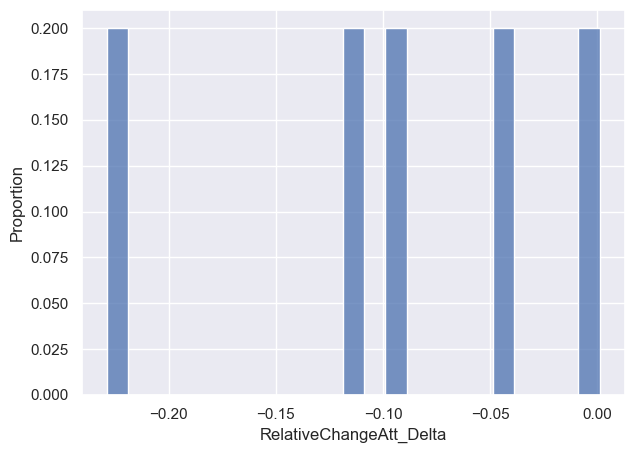

In [103]:
#sort units(high, low)
sns.histplot(data = lowUnits, x = 'RelativeChangeAtt_Delta', binwidth = 0.01, stat = 'proportion')
plt.show()
#- Check how the distribution lies wrt 0 (test for significantly positive values)

In [107]:
len(lowUnits[lowUnits.RelativeChangeAtt_Delta >= 0])/len(lowUnits.RelativeChangeAtt_Delta)

0.0

0.002184654585684913
0.0036377112161955828


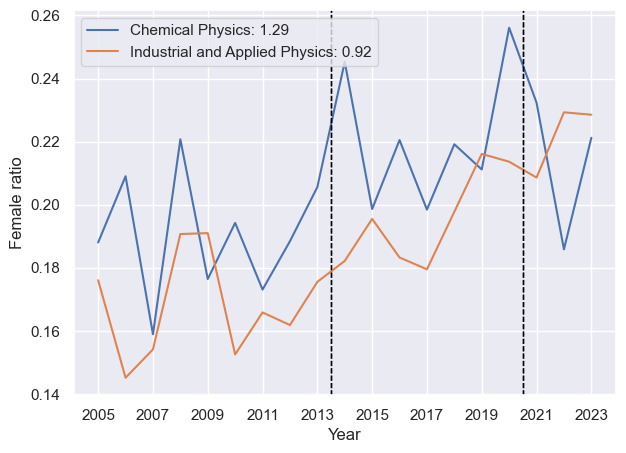

0.002184654585684913
0.0032976659714697544


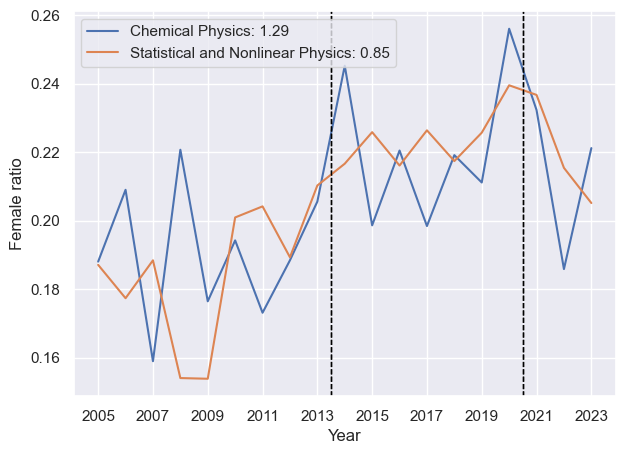

0.004760576032877645
0.0036377112161955828


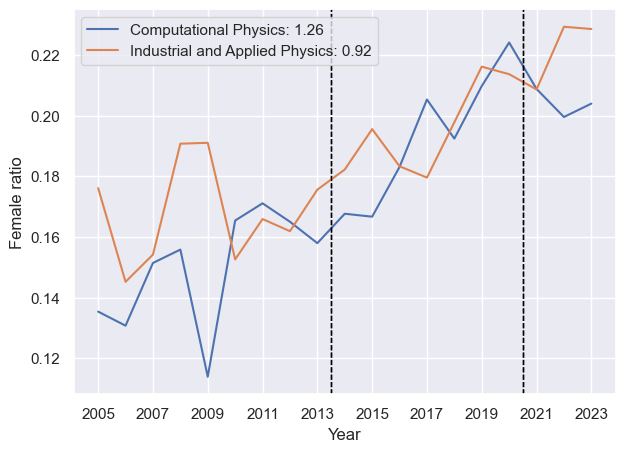

0.004760576032877645
0.0032976659714697544


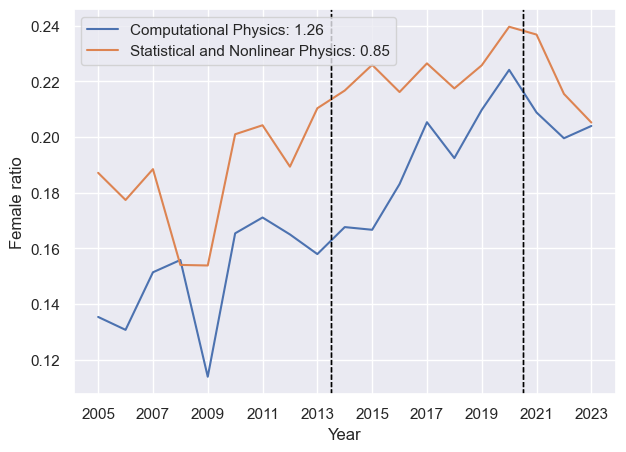

0.003751639347051402
0.00434283269159297


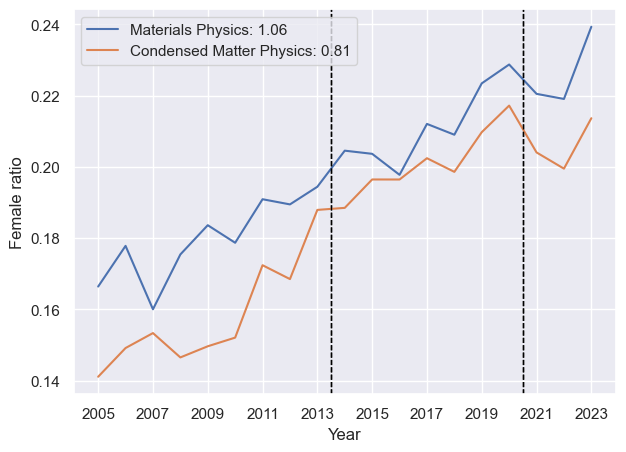

0.003751639347051402
0.0036377112161955828


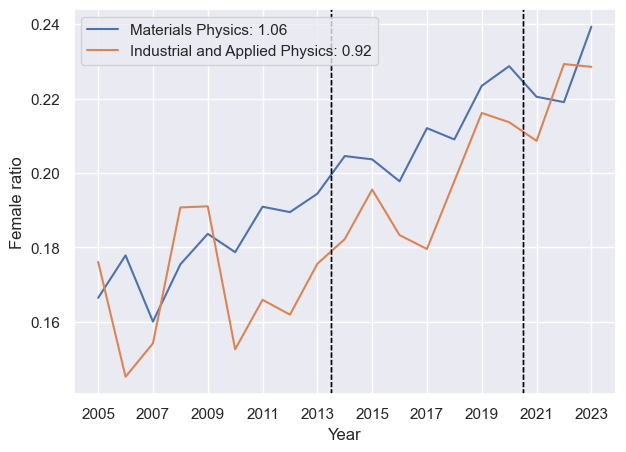

In [40]:
unitsToPlot = sortedEvalUnits.to_dict('records')

for i in unitsToPlot:
    unit_i = i['SponsoringUnit']
    unit_j = i['NeighborUnit']
    
    plotGenderRatio(unit_i, unit_j, sponsUnitResearchers, interventionLikelihood)

In [41]:
#evaluationDict = {}
#index = 0
#for i in similarUnit_eval.SponsoringUnit.unique():
#    attendeesUnit = evaluationData[(evaluationData.SponsoringUnitName == i) & (evaluationData.SessionType == 'attendee')]
#    genderRatio = pd.crosstab(index = attendeesUnit.Year, columns = attendeesUnit.Gender, normalize = 'index')
#    avgFemaleRatio = genderRatio.Female.mean()
#    evaluationDict[index] = {'SponsoringUnit': i, 'FemaleAttRatio': avgFemaleRatio}
#    index += 1

In [42]:
#femaleAtt_df = pd.DataFrame.from_dict(evaluationDict, orient = 'index')

In [43]:
#add column with evaluation difference as difference of avg female attendee ratio in evaluation period
#evaluation_df['FemaleRatioChangeDelta'] = evaluation_df.FemaleAttRatio_SponsoringUnit - evaluation_df.FemaleAttRatio_neighbor

In [44]:
#evalPlotData = evaluation_df[evaluation_df.LikelihoodDifference.abs() >= quantile_75].reset_index(drop = True)

In [45]:
#unique pairs
#evalPlotData_unique = evalPlotData.iloc[[0,1,2,3,6]]

In [46]:
#now do linear regression
#from sklearn.linear_model import LinearRegression
#from scipy import stats
import scipy


In [47]:
sortedEvalUnits

,SponsoringUnit,NeighborUnit,Distance,Likelihood_SponsoringUnit,Likelihood_Neighbor,LikelihoodDelta,RelativeChangeAtt_sponsoringUnit,RelativeChangeAtt_neighbor,RelativeChangeAtt_Delta
6,Chemical Physics,Industrial and Applied Physics,34.924108,High,Low,-0.042386,0.118751,0.321319,-0.202568
7,Chemical Physics,Statistical and Nonlinear Physics,29.916714,High,Low,-0.962736,0.118751,0.184044,-0.065293
8,Computational Physics,Industrial and Applied Physics,39.968399,High,Low,-0.352879,0.363987,0.321319,0.042668
9,Computational Physics,Statistical and Nonlinear Physics,43.988080,High,Low,-1.273229,0.363987,0.184044,0.179943
10,Materials Physics,Condensed Matter Physics,35.580463,High,Low,0.629306,0.259621,0.303292,-0.043671
11,Materials Physics,Industrial and Applied Physics,48.128247,High,Low,0.147191,0.259621,0.321319,-0.061697


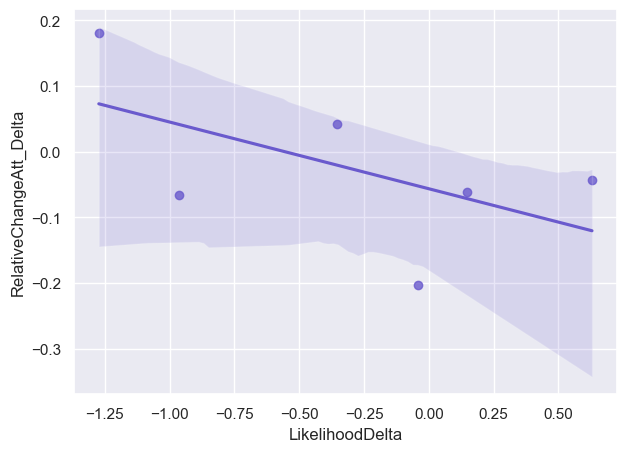

In [48]:
linReg = sns.regplot(data = sortedEvalUnits, x = 'LikelihoodDelta', y = 'RelativeChangeAtt_Delta', color = 'slateblue', ci=95)
slope, intercept, r, p, sterr = scipy.stats.linregress(x=linReg.get_lines()[0].get_xdata(),
                                                       y=linReg.get_lines()[0].get_ydata())
#plt.show()

In [49]:
print(slope)

-0.10157960492035743


In [50]:
x = sortedEvalUnits.LikelihoodDelta.values
X = sm.add_constant(x)
y = sortedEvalUnits.RelativeChangeAtt_Delta.values

In [51]:
model = sm.OLS(y, X).fit()
confidence_interval_slope = model.conf_int(alpha=0.05)[1]
confidence_interval_slope

array([-0.3075444 ,  0.10438519])

In [52]:
model.conf_int(alpha=0.05)[0]

array([-0.20435847,  0.09135151])

# Interpretation
Slope is the effect size, so 1 unit increase in likelihoodDifferences gives 0.20 decrease in effect, and 1 unit increase in likelihood relation, gives 0.22 decrease in effect. Seems that the the effect is significant when using likelihood differences, but not when using likelihood relation.



"This analysis aims to examine the effect of the independent variable on the dependent variable."


Reference to this: https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Mostly_Harmless_Statistics_(Webb)/12%3A_Correlation_and_Regression/12.02%3A_Simple_Linear_Regression/12.2.01%3A_Hypothesis_Test_for_Linear_Regression


In [ ]:
: B0 [intersection with y-axis] and B1 [slope]. When doing the regression, you can get B0 and B1 with 95% confidence intervals. If 0 is not part of B1 +/- confidence interval, the effect can be interpreted as significant.

In [327]:
#get confidence interval of slope and intercept

-0.21692085782515766

In [266]:
import statsmodels.api as sm

x =  evaluation_df.LikelihoodDifference.values
y =  evaluation_df.RelativeChangeDiff_eval.values

xs = sm.add_constant( x )
model = sm.OLS( y, xs )
results = model.fit()

In [270]:
conf = results.conf_int( alpha=0.05 )

In [ ]:
#y = df['Son'].values


#model2 = LinearRegression()
#model2.fit(X, y)

<AxesSubplot:xlabel='LikelihoodDifference', ylabel='RelativeChangeDiff_eval'>

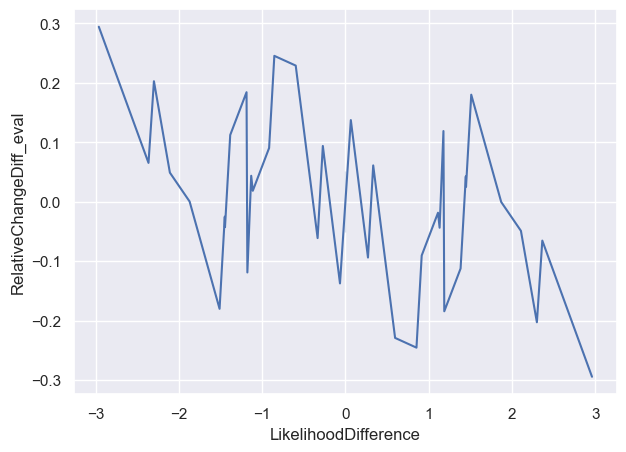

In [151]:
sns.lineplot(data = evaluation_df, x = 'LikelihoodDifference', y = 'RelativeChangeDiff_eval')

<AxesSubplot:xlabel='LikelihoodDifference', ylabel='RelativeChangeDiff_eval'>

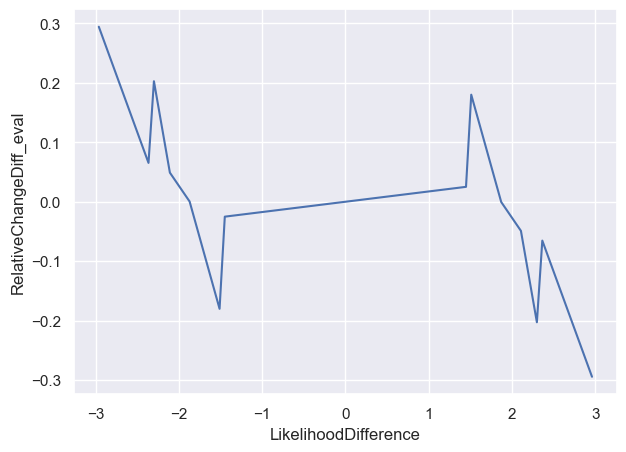

In [149]:
#how do we get intervention by having the difference of outcome
#or plot difference as x, and intervention as y
sns.lineplot(data = evalPlotData, x = 'LikelihoodDifference', y = 'RelativeChangeDiff_eval')

In [141]:
##difference in outcome as function of intervention


In [ ]:
#intervention have an impact

In [ ]:


#check fortegn

#significance of correlation
#pearson correlation

#permutation test